# Monte Carlo Option Pricing

## Introduction

Monte Carlo simulation is a powerful numerical technique for pricing financial derivatives, particularly options. This method is especially valuable when closed-form solutions (like Black-Scholes) are unavailable or when dealing with path-dependent options.

## Theoretical Foundation

### Geometric Brownian Motion

Under the risk-neutral measure, stock prices follow geometric Brownian motion (GBM):

$$dS_t = rS_t\,dt + \sigma S_t\,dW_t$$

where:
- $S_t$ is the stock price at time $t$
- $r$ is the risk-free interest rate
- $\sigma$ is the volatility
- $W_t$ is a standard Wiener process (Brownian motion)

### Solution to GBM

Applying Itô's lemma, the solution is:

$$S_T = S_0 \exp\left[\left(r - \frac{\sigma^2}{2}\right)T + \sigma\sqrt{T}Z\right]$$

where $Z \sim \mathcal{N}(0, 1)$ is a standard normal random variable.

### European Option Pricing

The price of a European call option is the discounted expected payoff under the risk-neutral measure:

$$C = e^{-rT}\mathbb{E}^{\mathbb{Q}}\left[\max(S_T - K, 0)\right]$$

Similarly, for a European put option:

$$P = e^{-rT}\mathbb{E}^{\mathbb{Q}}\left[\max(K - S_T, 0)\right]$$

where $K$ is the strike price and $T$ is the time to maturity.

### Monte Carlo Estimation

The Monte Carlo estimator approximates the expected value by averaging over $N$ simulated paths:

$$\hat{C} = e^{-rT}\frac{1}{N}\sum_{i=1}^{N}\max(S_T^{(i)} - K, 0)$$

The standard error of this estimator is:

$$\text{SE} = \frac{\hat{\sigma}_{\text{payoff}}}{\sqrt{N}}$$

where $\hat{\sigma}_{\text{payoff}}$ is the sample standard deviation of the discounted payoffs.

### Black-Scholes Formula (for validation)

For European options, the closed-form Black-Scholes solution provides a benchmark:

$$C = S_0\Phi(d_1) - Ke^{-rT}\Phi(d_2)$$

$$P = Ke^{-rT}\Phi(-d_2) - S_0\Phi(-d_1)$$

where:

$$d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}$$

$$d_2 = d_1 - \sigma\sqrt{T}$$

and $\Phi(\cdot)$ is the standard normal cumulative distribution function.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

## Implementation

### Black-Scholes Analytical Solution

First, we implement the Black-Scholes formula to validate our Monte Carlo results.

In [2]:
def black_scholes(S0, K, T, r, sigma, option_type='call'):
    """
    Calculate Black-Scholes option price.
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity (in years)
    r : float
        Risk-free interest rate
    sigma : float
        Volatility
    option_type : str
        'call' or 'put'
    
    Returns:
    --------
    float : Option price
    """
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    
    return price

### Monte Carlo Option Pricing

In [3]:
def monte_carlo_option_price(S0, K, T, r, sigma, n_simulations, option_type='call'):
    """
    Price a European option using Monte Carlo simulation.
    
    Parameters:
    -----------
    S0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity (in years)
    r : float
        Risk-free interest rate
    sigma : float
        Volatility
    n_simulations : int
        Number of Monte Carlo simulations
    option_type : str
        'call' or 'put'
    
    Returns:
    --------
    tuple : (price, standard_error, payoffs)
    """
    # Generate random standard normal samples
    Z = np.random.standard_normal(n_simulations)
    
    # Simulate terminal stock prices using GBM solution
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    # Calculate payoffs
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)
    
    # Discount payoffs to present value
    discounted_payoffs = np.exp(-r * T) * payoffs
    
    # Calculate price and standard error
    price = np.mean(discounted_payoffs)
    std_error = np.std(discounted_payoffs) / np.sqrt(n_simulations)
    
    return price, std_error, discounted_payoffs

## Numerical Experiments

### Parameter Setup

In [4]:
# Option parameters
S0 = 100      # Initial stock price
K = 105       # Strike price
T = 1.0       # Time to maturity (1 year)
r = 0.05      # Risk-free rate (5%)
sigma = 0.2   # Volatility (20%)

# Monte Carlo parameters
n_simulations = 100000

print("Option Parameters:")
print(f"  Initial Stock Price (S0): ${S0}")
print(f"  Strike Price (K): ${K}")
print(f"  Time to Maturity (T): {T} year")
print(f"  Risk-free Rate (r): {r*100}%")
print(f"  Volatility (σ): {sigma*100}%")
print(f"  Number of Simulations: {n_simulations:,}")

Option Parameters:
  Initial Stock Price (S0): $100
  Strike Price (K): $105
  Time to Maturity (T): 1.0 year
  Risk-free Rate (r): 5.0%
  Volatility (σ): 20.0%
  Number of Simulations: 100,000


### Pricing Results

In [5]:
# Calculate prices for both call and put options
call_mc, call_se, call_payoffs = monte_carlo_option_price(S0, K, T, r, sigma, n_simulations, 'call')
put_mc, put_se, put_payoffs = monte_carlo_option_price(S0, K, T, r, sigma, n_simulations, 'put')

# Black-Scholes benchmark
call_bs = black_scholes(S0, K, T, r, sigma, 'call')
put_bs = black_scholes(S0, K, T, r, sigma, 'put')

print("\nPricing Results:")
print("="*60)
print(f"{'Method':<20} {'Call Price':>15} {'Put Price':>15}")
print("-"*60)
print(f"{'Black-Scholes':<20} ${call_bs:>13.4f} ${put_bs:>13.4f}")
print(f"{'Monte Carlo':<20} ${call_mc:>13.4f} ${put_mc:>13.4f}")
print(f"{'MC Std Error':<20} ${call_se:>13.4f} ${put_se:>13.4f}")
print("-"*60)
print(f"{'Absolute Error':<20} ${abs(call_mc - call_bs):>13.4f} ${abs(put_mc - put_bs):>13.4f}")
print(f"{'Relative Error (%)':<20} {abs(call_mc - call_bs)/call_bs*100:>14.2f} {abs(put_mc - put_bs)/put_bs*100:>14.2f}")

# Verify put-call parity
parity_lhs = call_mc - put_mc
parity_rhs = S0 - K * np.exp(-r * T)
print(f"\nPut-Call Parity Check:")
print(f"  C - P = ${parity_lhs:.4f}")
print(f"  S0 - K*exp(-rT) = ${parity_rhs:.4f}")
print(f"  Difference: ${abs(parity_lhs - parity_rhs):.6f}")


Pricing Results:
Method                    Call Price       Put Price
------------------------------------------------------------
Black-Scholes        $       8.0214 $       7.9004
Monte Carlo          $       8.0416 $       7.8835
MC Std Error         $       0.0418 $       0.0327
------------------------------------------------------------
Absolute Error       $       0.0203 $       0.0169
Relative Error (%)             0.25           0.21

Put-Call Parity Check:
  C - P = $0.1581
  S0 - K*exp(-rT) = $0.1209
  Difference: $0.037178


### Convergence Analysis

We now analyze how the Monte Carlo estimate converges to the true value as the number of simulations increases.

In [6]:
# Convergence analysis
simulation_counts = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000]
call_prices = []
call_errors = []

np.random.seed(42)  # Reset seed for reproducibility

for n in simulation_counts:
    price, se, _ = monte_carlo_option_price(S0, K, T, r, sigma, n, 'call')
    call_prices.append(price)
    call_errors.append(se)

call_prices = np.array(call_prices)
call_errors = np.array(call_errors)

print("\nConvergence Analysis:")
print("="*70)
print(f"{'N':>10} {'MC Price':>12} {'Std Error':>12} {'Abs Error':>12} {'95% CI':>20}")
print("-"*70)
for i, n in enumerate(simulation_counts):
    abs_err = abs(call_prices[i] - call_bs)
    ci_low = call_prices[i] - 1.96 * call_errors[i]
    ci_high = call_prices[i] + 1.96 * call_errors[i]
    print(f"{n:>10,} ${call_prices[i]:>10.4f} ${call_errors[i]:>10.4f} ${abs_err:>10.4f} [{ci_low:.3f}, {ci_high:.3f}]")


Convergence Analysis:
         N     MC Price    Std Error    Abs Error               95% CI
----------------------------------------------------------------------
       100 $    5.9248 $    1.0111 $    2.0966 [3.943, 7.906]
       500 $    7.9314 $    0.6168 $    0.0900 [6.722, 9.140]
     1,000 $    8.8605 $    0.4364 $    0.8392 [8.005, 9.716]
     5,000 $    7.8044 $    0.1844 $    0.2170 [7.443, 8.166]
    10,000 $    8.1515 $    0.1336 $    0.1301 [7.890, 8.413]
    50,000 $    8.0510 $    0.0588 $    0.0296 [7.936, 8.166]
   100,000 $    8.0169 $    0.0417 $    0.0045 [7.935, 8.099]
   500,000 $    8.0144 $    0.0187 $    0.0070 [7.978, 8.051]


## Visualization

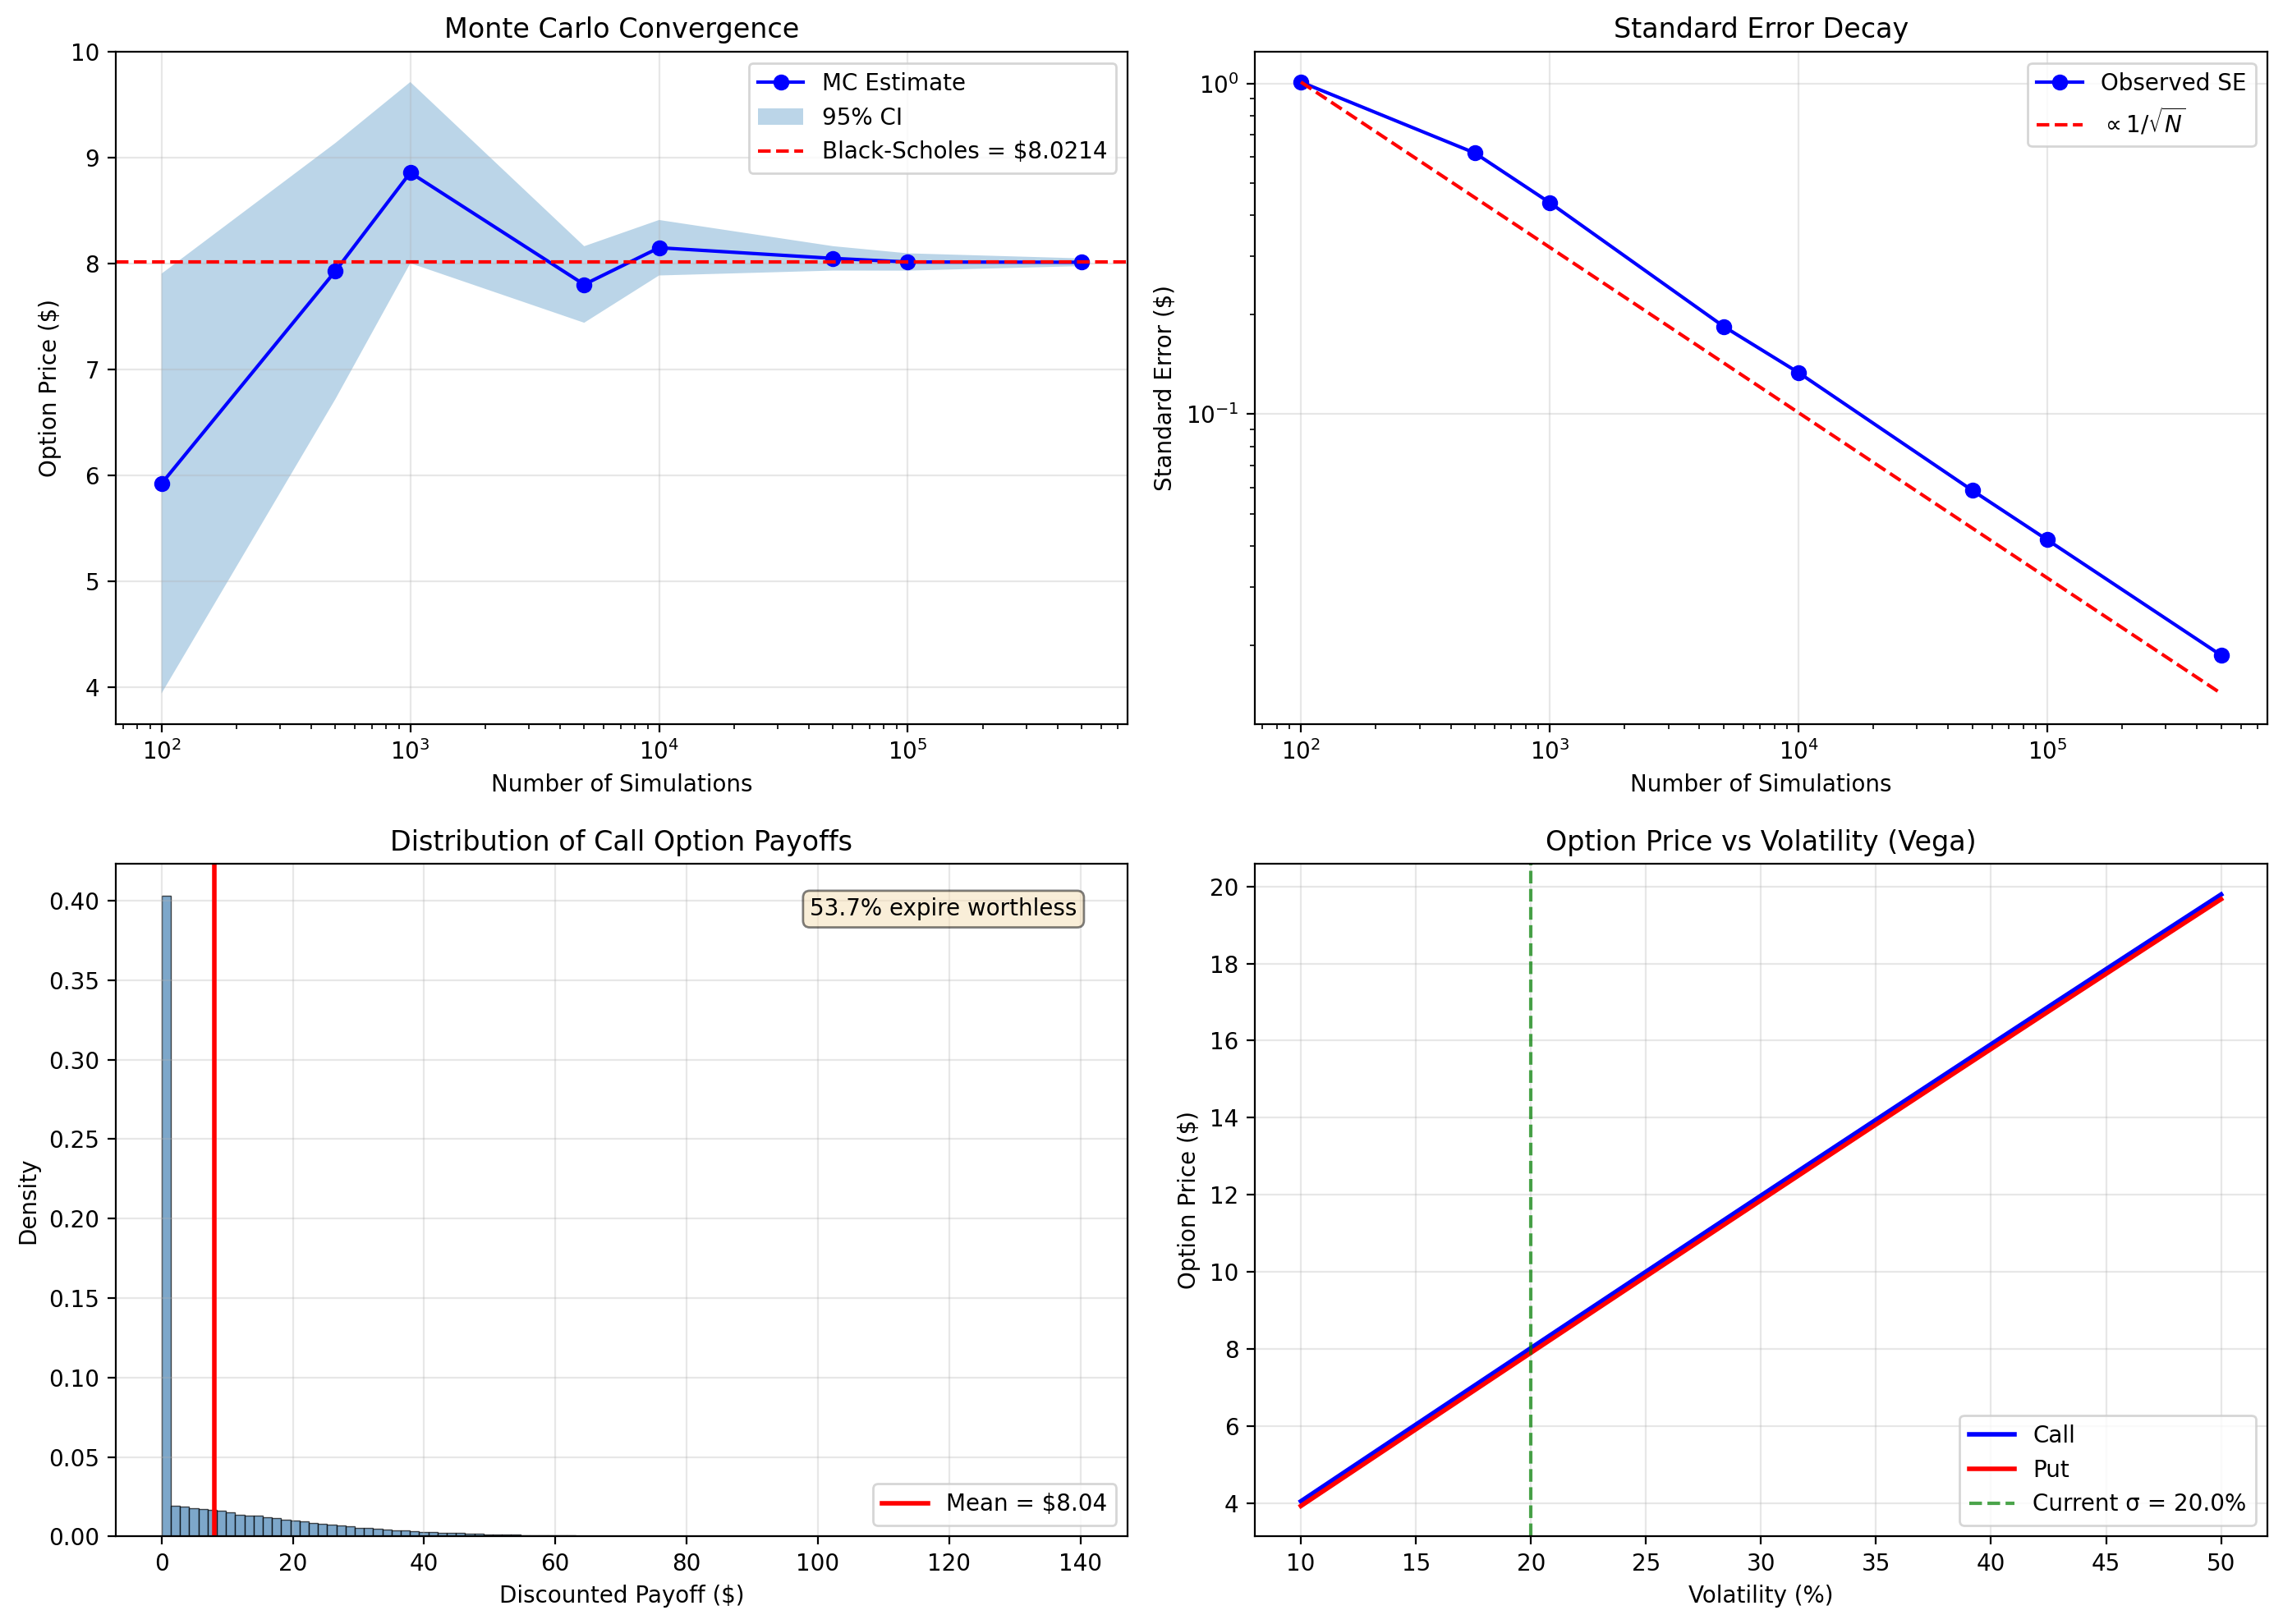


Figure saved to 'plot.png'


In [7]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Convergence of Monte Carlo estimate
ax1 = axes[0, 0]
ax1.plot(simulation_counts, call_prices, 'b-o', label='MC Estimate', markersize=6)
ax1.fill_between(simulation_counts, 
                  call_prices - 1.96 * call_errors, 
                  call_prices + 1.96 * call_errors, 
                  alpha=0.3, label='95% CI')
ax1.axhline(y=call_bs, color='r', linestyle='--', label=f'Black-Scholes = ${call_bs:.4f}')
ax1.set_xscale('log')
ax1.set_xlabel('Number of Simulations')
ax1.set_ylabel('Option Price ($)')
ax1.set_title('Monte Carlo Convergence')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Standard error decay (should follow 1/sqrt(N))
ax2 = axes[0, 1]
theoretical_se = call_errors[0] * np.sqrt(simulation_counts[0]) / np.sqrt(simulation_counts)
ax2.loglog(simulation_counts, call_errors, 'b-o', label='Observed SE', markersize=6)
ax2.loglog(simulation_counts, theoretical_se, 'r--', label=r'$\propto 1/\sqrt{N}$')
ax2.set_xlabel('Number of Simulations')
ax2.set_ylabel('Standard Error ($)')
ax2.set_title('Standard Error Decay')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Distribution of simulated payoffs
ax3 = axes[1, 0]
# Use the payoffs from the main simulation
nonzero_payoffs = call_payoffs[call_payoffs > 0]
ax3.hist(call_payoffs, bins=100, density=True, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax3.axvline(x=call_mc, color='r', linestyle='-', linewidth=2, label=f'Mean = ${call_mc:.2f}')
ax3.set_xlabel('Discounted Payoff ($)')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of Call Option Payoffs')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add text annotation for percentage of zero payoffs
pct_zero = np.sum(call_payoffs == 0) / len(call_payoffs) * 100
ax3.text(0.95, 0.95, f'{pct_zero:.1f}% expire worthless', 
         transform=ax3.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 4: Option price sensitivity to volatility
ax4 = axes[1, 1]
sigmas = np.linspace(0.1, 0.5, 50)
call_prices_sigma = [black_scholes(S0, K, T, r, s, 'call') for s in sigmas]
put_prices_sigma = [black_scholes(S0, K, T, r, s, 'put') for s in sigmas]

ax4.plot(sigmas * 100, call_prices_sigma, 'b-', label='Call', linewidth=2)
ax4.plot(sigmas * 100, put_prices_sigma, 'r-', label='Put', linewidth=2)
ax4.axvline(x=sigma * 100, color='g', linestyle='--', alpha=0.7, label=f'Current σ = {sigma*100}%')
ax4.set_xlabel('Volatility (%)')
ax4.set_ylabel('Option Price ($)')
ax4.set_title('Option Price vs Volatility (Vega)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('monte_carlo_option_pricing_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to 'plot.png'")

## Variance Reduction Techniques

We can improve Monte Carlo efficiency using variance reduction techniques. Here we demonstrate the **antithetic variates** method.

In [8]:
def monte_carlo_antithetic(S0, K, T, r, sigma, n_simulations, option_type='call'):
    """
    Price option using Monte Carlo with antithetic variates.
    
    Antithetic variates use both Z and -Z for each random draw,
    reducing variance by inducing negative correlation.
    """
    # Generate n/2 random samples
    n_half = n_simulations // 2
    Z = np.random.standard_normal(n_half)
    
    # Simulate terminal prices using both Z and -Z
    ST_plus = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    ST_minus = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * (-Z))
    
    # Calculate payoffs
    if option_type == 'call':
        payoffs_plus = np.maximum(ST_plus - K, 0)
        payoffs_minus = np.maximum(ST_minus - K, 0)
    else:
        payoffs_plus = np.maximum(K - ST_plus, 0)
        payoffs_minus = np.maximum(K - ST_minus, 0)
    
    # Average the paired payoffs
    payoffs_avg = (payoffs_plus + payoffs_minus) / 2
    
    # Discount to present value
    discounted_payoffs = np.exp(-r * T) * payoffs_avg
    
    price = np.mean(discounted_payoffs)
    std_error = np.std(discounted_payoffs) / np.sqrt(n_half)
    
    return price, std_error

# Compare standard MC with antithetic variates
np.random.seed(42)
n_test = 100000

# Standard Monte Carlo
mc_price, mc_se, _ = monte_carlo_option_price(S0, K, T, r, sigma, n_test, 'call')

# Antithetic variates
np.random.seed(42)
av_price, av_se = monte_carlo_antithetic(S0, K, T, r, sigma, n_test, 'call')

print("\nVariance Reduction Comparison:")
print("="*60)
print(f"{'Method':<25} {'Price':>12} {'Std Error':>12} {'Variance':>12}")
print("-"*60)
print(f"{'Standard MC':<25} ${mc_price:>10.4f} ${mc_se:>10.4f} {mc_se**2:>12.6f}")
print(f"{'Antithetic Variates':<25} ${av_price:>10.4f} ${av_se:>10.4f} {av_se**2:>12.6f}")
print(f"{'Black-Scholes':<25} ${call_bs:>10.4f}")
print("-"*60)
variance_reduction = (1 - (av_se / mc_se)**2) * 100
print(f"Variance Reduction: {variance_reduction:.1f}%")


Variance Reduction Comparison:
Method                           Price    Std Error     Variance
------------------------------------------------------------
Standard MC               $    8.0416 $    0.0418     0.001744
Antithetic Variates       $    8.0231 $    0.0331     0.001097
Black-Scholes             $    8.0214
------------------------------------------------------------
Variance Reduction: 37.1%


## Conclusion

This notebook demonstrated Monte Carlo simulation for pricing European options. Key findings:

1. **Accuracy**: Monte Carlo estimates converge to Black-Scholes analytical values as $N \to \infty$
2. **Convergence Rate**: Standard error decreases as $\mathcal{O}(1/\sqrt{N})$, requiring 100× more samples for 10× precision improvement
3. **Variance Reduction**: Antithetic variates can significantly reduce variance, improving efficiency
4. **Flexibility**: Monte Carlo methods extend naturally to path-dependent and exotic options where closed-form solutions don't exist

The technique's power lies in its versatility—it can price virtually any derivative security, including American options (with modifications), Asian options, barrier options, and other exotic derivatives.